In [70]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import einops
from einops.layers.torch import Rearrange, Reduce

In [71]:
config = {
    "epoch": 30,
    "batch_size": 512,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
}

In [72]:
class MNIST(datasets.MNIST):
    def __init__(self, root: str, train: bool = True, transform = None, download: bool = False) -> None:
        super().__init__(root=root, train=train, transform=transform, download=download)
    
    def __getitem__(self, index: int):
        image, label = self.data[index], self.targets[index]
        
        if self.transform is not None:
            transform = self.transform(image=image.unsqueeze(2).numpy())
            image = transform["image"]
            
        return image, label

In [73]:
transform = albumentations.Compose([
    albumentations.Normalize(mean=0, std=1),
    albumentations.Blur(blur_limit=4),
    ToTensorV2()
])

In [74]:
mnist_train = MNIST(root='/Users/jemin/Library/CloudStorage/GoogleDrive-jemin7709@gmail.com/내 드라이브/BoostCamp_Data/data', train=True, transform=transform, download=True)
mnist_valid = MNIST(root='/Users/jemin/Library/CloudStorage/GoogleDrive-jemin7709@gmail.com/내 드라이브/BoostCamp_Data/data', train=False, transform=transform, download=True)
train_data = DataLoader(mnist_train, config["batch_size"], shuffle=True)
valid_data = DataLoader(mnist_valid, config["batch_size"])

In [75]:
print(mnist_train[0][0].shape)

torch.Size([1, 28, 28])


In [76]:
class PositionEmbedding(nn.Module):
    def __init__(self, in_channels, img_size, patch_size, emb_dim) -> None:
        super().__init__()
        self.rerange = Rearrange("b c (w p1) (h p2) -> b (w h) (p1 p2 c)", p1=patch_size, p2=patch_size)
        self.linear = nn.Linear(in_channels * patch_size ** 2, emb_dim)

        self.token = nn.Parameter(torch.randn((1, 1, emb_dim)))

        num_patches = img_size ** 2 // patch_size ** 2
        self.position = nn.Parameter(torch.randn((num_patches + 1, emb_dim)))
    
    def forward(self, x):
        b, _, _, _ = x.shape

        x = self.rerange(x)
        x = self.linear(x)

        c = einops.repeat(self.token, "() n d -> b n d", b=b)
        x = torch.cat([c, x], dim=1)
        x = x + self.position

        return x

In [77]:
x = torch.zeros((2, 2, 3, 4, 5))
x1 = x[0]
x2 = x[1]
print(x1.shape, x2.shape)
print(torch.matmul(x1, x2.transpose(-2, -1)).shape)

torch.Size([2, 3, 4, 5]) torch.Size([2, 3, 4, 5])
torch.Size([2, 3, 4, 4])


In [78]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads) -> None:
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads

        self.qkv = nn.Linear(emb_dim, emb_dim * 3)
        self.attention_dropout = nn.Dropout()
        self.linear = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, x):
        qkv = einops.rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        Q = qkv[0]
        K = qkv[1]
        V = qkv[2]

        weight = torch.matmul(Q, K.transpose(-2, -1)) # b h n d -> b h n n
        scaling = self.emb_dim ** (1/2)
        A = F.softmax(weight / scaling, dim=-1)
        A = self.attention_dropout(A)
        SA = torch.matmul(A, V) # b h n n -> b h n d
        
        out = einops.rearrange(SA, "b h n d -> b n (h d)") # flatten
        out = self.linear(out)
        return out, A


In [79]:
class MLPBlock(nn.Module):
    def __init__(self, emb_dim, forward_dim) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(emb_dim, forward_dim * emb_dim),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(forward_dim * emb_dim, emb_dim)
        )
    
    def forward(self, x):
        x = self.block(x)
        return x 

In [80]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, num_heads, forward_dim) -> None:
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.mha = MultiHeadAttention(emb_dim, num_heads)

        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = MLPBlock(emb_dim, forward_dim)

        self.dropout = nn.Dropout()
    
    def forward(self, x):
        out = self.norm1(x)
        out, attention = self.mha(out)
        x = x + self.dropout(out)

        out = self.norm2(x)
        out = self.mlp(out)
        x = x + self.dropout(out)

        return out, attention

In [81]:
class VIT(nn.Module):
    def __init__(self, in_channel, img_size, patch_size, emb_dim, n_layer, num_heads, forward_dim, num_classes) -> None:
        super().__init__()
        self.img_emb = PositionEmbedding(in_channel, img_size, patch_size, emb_dim)
        self.encoder = nn.ModuleList([Encoder(emb_dim, num_heads, forward_dim)] * n_layer)
        self.reduce = Reduce("b n e -> b e", reduction="mean")
        self.norm = nn.LayerNorm(emb_dim)
        self.fc = nn.Linear(emb_dim, num_classes)
    
    def forward(self, x):
        x = self.img_emb(x)
        attentions = []
        for encoder in self.encoder:
            x, attention = encoder(x)
            attentions.append(attention)
        x = self.reduce(x)
        x = self.norm(x)
        x = self.fc(x)
        return x, attentions

In [82]:
model = VIT(1, 28, 4, 4*4, 3, 2, 4, 10).to(config["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), config["lr"])

In [83]:
total_train = {
    "loss": [],
    "acc": [],
}
total_valid = {
    "loss": [],
    "acc": [],
}
for i in range(1, config["epoch"] + 1):
    model.train()
    train_acc = []
    train_loss = []
    for image, label in train_data:
        image, label = image.to(config["device"]), label.to(config["device"])
        pred, attentions = model(image)
        loss = criterion(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append((pred.max(1)[1] == label).float().mean().item())

    with torch.no_grad():
        model.eval()
        valid_acc = []
        valid_loss = []
        for image, label in valid_data:
            image, label = image.to(config["device"]), label.to(config["device"])

            pred, attentions = model(image)
            loss = criterion(pred, label)
            
            valid_loss.append(loss.item())
            valid_acc.append((pred.max(1)[1] == label).float().mean().item())
    
    total_train["loss"].append(np.mean(train_loss))
    total_train["acc"].append(np.mean(train_acc))
    total_valid["loss"].append(np.mean(valid_loss))
    total_valid["acc"].append(np.mean(valid_acc))
    
    if i % 10 == 0:
        print(f"epoch: {i}/{config['epoch']}")
        print(f"acc".ljust(5), f"train: {np.mean(train_acc):.3f}, valid: {np.mean(valid_acc):.3f}")
        print(f"loss".ljust(5), f"train: {np.mean(train_loss):.3f}, valid: {np.mean(valid_loss):.3f}")

epoch: 10/30
acc   train: 0.644, valid: 0.742
loss  train: 1.031, valid: 0.822
epoch: 20/30
acc   train: 0.788, valid: 0.831
loss  train: 0.656, valid: 0.534
epoch: 30/30
acc   train: 0.832, valid: 0.867
loss  train: 0.527, valid: 0.426


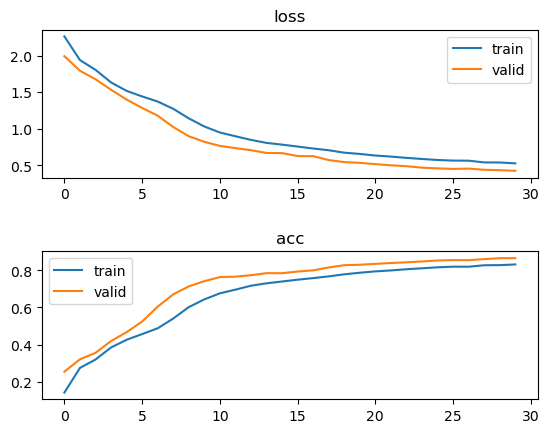

In [95]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title("loss")
ax[0].plot(np.arange(config["epoch"]), total_train["loss"], label="train")
ax[0].plot(np.arange(config["epoch"]), total_valid["loss"], label="valid")
ax[0].legend()
ax[1].set_title("acc")
ax[1].plot(np.arange(config["epoch"]), total_train["acc"], label="train")
ax[1].plot(np.arange(config["epoch"]), total_valid["acc"], label="valid")
ax[1].legend()
plt.subplots_adjust(hspace=0.5)
plt.show()